<a href="https://colab.research.google.com/github/lindahe8989/multi-agent-communication/blob/main/autoencoders.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
import torch
import torch.nn as nn
import torch.nn.functional as F
from torch.utils.data import DataLoader
from torchvision import datasets, transforms

from io import BytesIO
from PIL import Image

import numpy as np
import matplotlib.pyplot as plt

import itertools
from tqdm.notebook import tqdm

In [2]:
cuda_available = torch.cuda.is_available()
print(cuda_available)

True


In [3]:
# Get data

to_pil = transforms.ToPILImage()
to_tensor = transforms.ToTensor()

class ToRGB(nn.Module):
  def forward(self, img):
    return to_tensor(img).tile(dims=(3,1,1))

train_data = datasets.MNIST(root='./data', train=True, download=True, transform=ToRGB())
train_loader = DataLoader(train_data, batch_size=64, shuffle=True)

test_data = datasets.MNIST(root='./data', train=False, download=True, transform=ToRGB())
test_loader = DataLoader(test_data, batch_size=4096, shuffle=True)

100%|██████████| 9912422/9912422 [00:00<00:00, 278375847.80it/s]


Extracting ./data/MNIST/raw/train-images-idx3-ubyte.gz to ./data/MNIST/raw



100%|██████████| 28881/28881 [00:00<00:00, 77254906.78it/s]


Extracting ./data/MNIST/raw/train-labels-idx1-ubyte.gz to ./data/MNIST/raw



100%|██████████| 1648877/1648877 [00:00<00:00, 153125017.08it/s]


Extracting ./data/MNIST/raw/t10k-images-idx3-ubyte.gz to ./data/MNIST/raw



100%|██████████| 4542/4542 [00:00<00:00, 19340638.34it/s]


Extracting ./data/MNIST/raw/t10k-labels-idx1-ubyte.gz to ./data/MNIST/raw



In [4]:

class Encoder(nn.Module):
    """
    A convolutional encoder.

    For the MNIST dataset this will be:
    3 x 28 x 28 image ->
    16 x 10 x 10 representation ->
    32 x 4 x 4 representation ->
    hidden_size latent space.
    """
    def __init__(self, input_size, hidden_size):
        super().__init__()
        self.convolutions = nn.ModuleList([
            nn.Conv2d(3, 16, kernel_size=3, stride=3, padding=1),
            nn.Conv2d(16, 32, kernel_size=3, stride=3, padding=1),
        ])
        conv_size = 32 * ((input_size+8)//9)**2
        self.fc = nn.Linear(conv_size, hidden_size)

    def forward(self, x):
        for conv in self.convolutions:
            x = F.elu(conv(x))
        x = x.view(x.shape[0], -1)
        return torch.tanh(self.fc(x))

class Decoder(nn.Module):
    """
    The reverse process.
    """
    def __init__(self, hidden_size, output_size):
        super().__init__()
        self.fc = nn.Linear(hidden_size, 32 * ((output_size+8)//9)**2)
        self.deconvolutions = nn.ModuleList([
            nn.ConvTranspose2d(32, 16, kernel_size=3, stride=3, padding=1),
            nn.ConvTranspose2d(16, 3, kernel_size=3, stride=3, padding=1),
        ])

    def forward(self, x):
        x = F.elu(self.fc(x))
        x = x.view(x.shape[0], 32, 4, 4)
        for deconv in self.deconvolutions:
            x = F.elu(deconv(x))
        return x

In [5]:
def train_autoencoder(encoder, decoder, optim, epochs=10):
  encoder.train()
  decoder.train()

  for epoch in range(epochs):
    total_loss = 0
    pbar = tqdm(train_loader)
    for batch_idx, (img, label) in enumerate(pbar):
      if cuda_available:
        img = img.cuda()

      optim.zero_grad()

      output = decoder(encoder(img))
      loss = F.mse_loss(output, img)

      loss.backward()
      optim.step()

      total_loss += loss.item()
      if batch_idx % 1 == 0:
        pbar.set_description('Train Epoch: {} [{}/{} ({:.0f}%)]\tLoss: {:.6f}'.format(
          epoch, batch_idx * len(img), len(train_loader.dataset),
          100. * batch_idx / len(train_loader), total_loss / (1 + batch_idx)))

In [6]:
def test_autoencoder(encoder, decoder):
  encoder.eval()
  decoder.eval()

  with torch.no_grad():
    total_loss = 0
    for (img, label) in test_loader:
      if cuda_available:
        img = img.cuda()

      output = decoder(encoder(img))
      loss = F.mse_loss(output, img)
      total_loss += loss.item()

  return total_loss / len(test_loader)

In [7]:
encoder = Encoder(28, 32)
decoder = Decoder(32, 28)
if cuda_available:
  encoder = encoder.cuda()
  decoder = decoder.cuda()

# Train w/ Adam
optim = torch.optim.Adam(itertools.chain(encoder.parameters(), decoder.parameters()))
train_autoencoder(encoder, decoder, optim, 10)
print(test_autoencoder(encoder, decoder))

  0%|          | 0/938 [00:00<?, ?it/s]

  0%|          | 0/938 [00:00<?, ?it/s]

  0%|          | 0/938 [00:00<?, ?it/s]

  0%|          | 0/938 [00:00<?, ?it/s]

  0%|          | 0/938 [00:00<?, ?it/s]

  0%|          | 0/938 [00:00<?, ?it/s]

  0%|          | 0/938 [00:00<?, ?it/s]

  0%|          | 0/938 [00:00<?, ?it/s]

  0%|          | 0/938 [00:00<?, ?it/s]

  0%|          | 0/938 [00:00<?, ?it/s]

0.00831284187734127


In [9]:
def plot_sample(idx=0):
  x, y = test_data[idx]

  fig, ax = plt.subplots(1, 2, figsize=(5, 10))

  with torch.no_grad():
    z = encoder(x.cuda().unsqueeze(0))
    decoded = decoder(z).squeeze().detach().clip(0, 1).cpu()

  # Plot
  ax[0].set_title("Original")
  ax[1].set_title("Decoded")
  ax[0].imshow(to_pil(x))
  ax[1].imshow(to_pil(decoded))
  ax[0].get_xaxis().set_visible(False)
  ax[1].get_xaxis().set_visible(False)
  ax[0].get_yaxis().set_visible(False)
  ax[1].get_yaxis().set_visible(False)
  plt.show()

#   plt.title("Latent Representation")
#   fig = plt.figure(figsize=(2, 10))
#   plt.gcf().set_size_inches(2, 10)
#   plt.axis("off")
#   plt.imshow(z.detach().cpu().numpy(), cmap="gray")
#   plt.show()
# plot_sample()

  0%|          | 0/938 [00:00<?, ?it/s]

BITS = 32 LOSS = 0.05999231959382693


  0%|          | 0/938 [00:00<?, ?it/s]

BITS = 64 LOSS = 0.054895484199126564


  0%|          | 0/938 [00:00<?, ?it/s]

BITS = 96 LOSS = 0.05167031288146973


  0%|          | 0/938 [00:00<?, ?it/s]

BITS = 128 LOSS = 0.04764707013964653


  0%|          | 0/938 [00:00<?, ?it/s]

BITS = 160 LOSS = 0.044156612207492195


  0%|          | 0/938 [00:00<?, ?it/s]

BITS = 192 LOSS = 0.04110977301994959


  0%|          | 0/938 [00:00<?, ?it/s]

BITS = 224 LOSS = 0.039576967557271324


  0%|          | 0/938 [00:00<?, ?it/s]

BITS = 256 LOSS = 0.03580231964588165


  0%|          | 0/938 [00:00<?, ?it/s]

BITS = 288 LOSS = 0.034707470486561455


  0%|          | 0/938 [00:00<?, ?it/s]

BITS = 320 LOSS = 0.035576814164717994


  0%|          | 0/938 [00:00<?, ?it/s]

BITS = 352 LOSS = 0.0317803310851256


  0%|          | 0/938 [00:00<?, ?it/s]

BITS = 384 LOSS = 0.031422339379787445


  0%|          | 0/938 [00:00<?, ?it/s]

BITS = 416 LOSS = 0.030440468961993854


  0%|          | 0/938 [00:00<?, ?it/s]

BITS = 448 LOSS = 0.029854919761419296


  0%|          | 0/938 [00:00<?, ?it/s]

BITS = 480 LOSS = 0.02813695805768172


  0%|          | 0/938 [00:00<?, ?it/s]

BITS = 512 LOSS = 0.02831851380566756


  0%|          | 0/938 [00:00<?, ?it/s]

BITS = 544 LOSS = 0.027120740463336308


  0%|          | 0/938 [00:00<?, ?it/s]

BITS = 576 LOSS = 0.02559607910613219


  0%|          | 0/938 [00:00<?, ?it/s]

BITS = 608 LOSS = 0.024876628071069717


  0%|          | 0/938 [00:00<?, ?it/s]

BITS = 640 LOSS = 0.024072548374533653


  0%|          | 0/938 [00:00<?, ?it/s]

BITS = 672 LOSS = 0.023290103301405907


  0%|          | 0/938 [00:00<?, ?it/s]

BITS = 704 LOSS = 0.02297474630177021


  0%|          | 0/938 [00:00<?, ?it/s]

BITS = 736 LOSS = 0.019907511149843533


  0%|          | 0/938 [00:00<?, ?it/s]

BITS = 768 LOSS = 0.022211469088991482


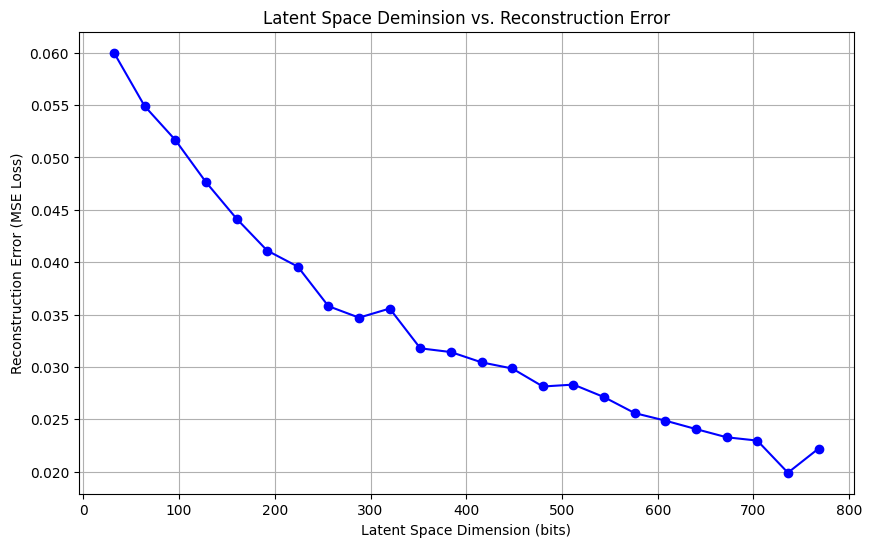

In [10]:
bits = []
loss = []
for dim_size in range(1, 25):
  bits.append(dim_size * 32)
  encoder = Encoder(28, dim_size)
  decoder = Decoder(dim_size, 28)

  if cuda_available:
    encoder = encoder.cuda()
    decoder = decoder.cuda()

  # Train w/ Adam
  optim = torch.optim.Adam(itertools.chain(encoder.parameters(), decoder.parameters()))
  train_autoencoder(encoder, decoder, optim, epochs=1)
  current_loss = test_autoencoder(encoder, decoder)
  loss.append(current_loss)

  print("BITS =", bits[-1], "LOSS =", current_loss)
#   plot_sample()

plt.figure(figsize=(10, 6))
plt.plot(bits, loss, marker='o', linestyle='-', color='b')
plt.title('Latent Space Deminsion vs. Reconstruction Error')
plt.xlabel('Latent Space Dimension (bits)')
plt.ylabel('Reconstruction Error (MSE Loss)')
plt.grid(True)
plt.show()



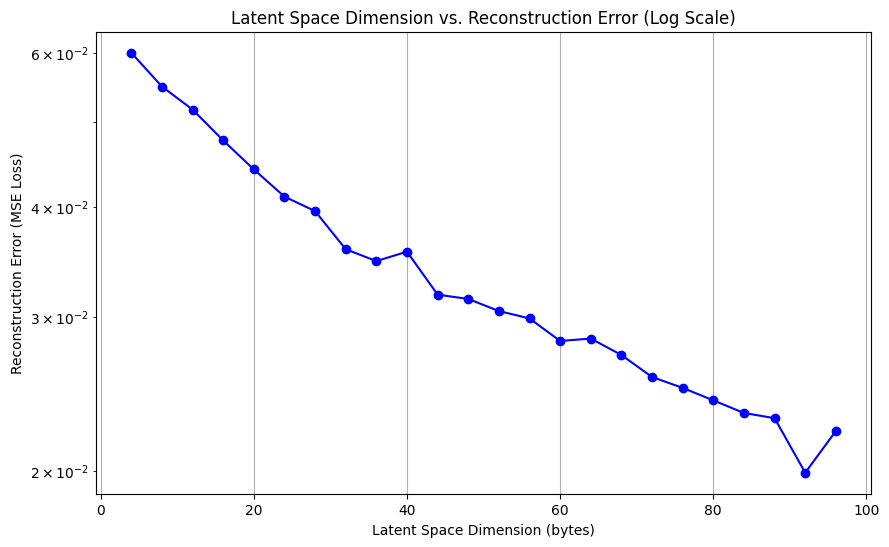

In [11]:
plt.figure(figsize=(10, 6))
plt.plot([b / 8 for b in bits], loss, marker='o', linestyle='-', color='b')  # Scale bits by dividing by 8
plt.title('Latent Space Dimension vs. Reconstruction Error (Log Scale)')
plt.xlabel('Latent Space Dimension (bytes)')
plt.ylabel('Reconstruction Error (MSE Loss)')
plt.yscale('log')  # Set the y-axis to a logarithmic scale
plt.grid(True)
plt.show()

In [12]:
import csv
bytes_values = [b / 8 for b in bits]

with open('latent_space_vs_loss.csv', mode='w', newline='') as file:
    writer = csv.writer(file)
    # Write the header
    writer.writerow(['Latent Space Dimension (bytes)', 'Reconstruction Error (MSE Loss)'])
    # Write the data
    for byte, loss_value in zip(bytes_values, loss):
        writer.writerow([byte, loss_value])

In [13]:
from google.colab import files
files.download('latent_space_vs_loss.csv')

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>